Practice with Distance-based and Adversarial Domain Adaptation Methods
---
You've seen in the lectures how a variety of domain adaptation (DA) techniques can improve the generalization capabilities of neural networks (NNs), even when labeled data is only available in one domain. In this tutorial, you'll get hands-on experience applying DA to address a covariate shift scenario—where the input data distribution changes between training and deployment domains, but the underlying classification task remains the same.

<img src="confused.png" alt="drawing" width="500"/>

We'll demonstrate this with a simple neural network trained on the [MNIST dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset) (source domain) and evaluated on the [MNIST-M dataset](https://www.kaggle.com/datasets/aquibiqbal/mnistm) (target domain). While both datasets have the same label space (10 classes), the pixel distributions differ significantly, providing a natural testbed for domain adaptation techniques. Our tutorial will use PyTorch, starting with the following imports:


In [ ]:
# torch related inputs
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms
from torchvision.datasets import MNIST, ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor
import copy


# miscellaneous
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import urllib.request
import random
import zipfile

# geomloss provides distance measure that are torch/CUDA compatible. uncomment line below to install it, if you don't have it installed.
# !pip install -q geomloss

import geomloss

def set_all_seeds(seed=42):

    os.environ["PYTHONHASHSEED"] = str(seed)  # For Python's hash seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Optional: enforce deterministic algorithms where possible
    torch.use_deterministic_algorithms(True, warn_only=True)
set_all_seeds()


Problem Setup
---

- **Neural Network**:  
Let $f_\theta$ denote a neural network classifier with parameters $\theta$, which maps an input image $x \in \mathbb{R}^n$ to predicted class probabilities $\hat{y} = f_\theta(x) \in \mathbb{R}^K$. The network is decomposed into a feature extractor $\phi_\theta : \mathbb{R}^n \rightarrow \mathbb{R}^d$ and a classifier head $g_\theta : \mathbb{R}^d \rightarrow \mathbb{R}^K$, such that $f_\theta(x) = \text{softmax}(g_\theta(\phi_\theta(x)))$.  
We define the **latent representation** $z = \phi_\theta(x)$ as the output of the final hidden layer (before the logits). This representation (also called the *latent vector* or *latent space*) will be used for domain alignment.

- **Source domain dataset**:  
$\mathcal{D}_s = \{(x_s^{(i)}, y_s^{(i)})\}_{i=1}^{N_s}$,  
where $x_s^{(i)} \sim p_s(x)$ are grayscale digit images from MNIST, and $y_s^{(i)} \in \{0, 1, \dots, 9\}$ are the corresponding digit labels.

- **Target domain dataset**:  
$\mathcal{D}_t = \{x_t^{(j)}\}_{j=1}^{N_t}$,  
where $x_t^{(j)} \sim p_t(x)$ are unlabeled images from MNIST-M.  
We assume the label distributions are aligned, i.e., $p_s(y|x) = p_t(y|x)$, but the input distributions differ: $p_s(x) \neq p_t(x)$.  
Our goal is to adapt $f_\theta$ using **only labeled source data** and **unlabeled target data**, so that it performs well on the target domain.

- **Classification loss**:  
On the source domain, we minimize the supervised cross-entropy loss between predicted and true labels:

$$
\mathcal{L}_{\text{CE}}(\theta) = -\frac{1}{N_s} \sum_{i=1}^{N_s} \log f_\theta^{(y_s^{(i)})}(x_s^{(i)}),
$$

where $f_\theta^{(k)}(x)$ denotes the predicted probability for class $k$, and $K = 10$ is the number of classes.

---
Let's start by defining our necessary ingredients, starting with the data. MNIST ($\mathcal{D}_s$) is readily available from `torchvision`, but we'll have to download MNIST-M ($\mathcal{D}_t$) from source. MNIST is single channel and MNISTM is three channel; we'll copy the single channel image across three channels so that the images can be loaded into the model properly. We will limit ourselves to a subset for the data so that you can train things rather quickly. 

Recall that images are typically normalized to be in the range [-1,1] for gradient stabilitiy during training. This is done via [z-score normalization](https://en.wikipedia.org/wiki/Standard_score). I've precalculated the means and standard deviations of the datasets for you. Feel free to check this yourself! This is an often not-discussed/overlooked aspect of training NNs, but data normalization is **immensely important**.


In [2]:
mnist_mean = (0.1307,) * 3 ## found online
mnist_std = (0.3015,) * 3 ## found online

mnistm_mean = (0.4579, 0.4621, 0.4082) #I've precalculated these
mnistm_std = (0.1880, 0.1755, 0.1956) #I've precalculated these

data_subset_size = 5000
train_subset_size = int(data_subset_size * 0.8)
test_subset_size = data_subset_size - train_subset_size

In [3]:
mnist_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std)
])
# Load MNIST

mnist_train = MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test = MNIST(root='./data', train=False, download=True, transform=mnist_transform)

train_indices = torch.randperm(len(mnist_train))[:train_subset_size]
test_indices = torch.randperm(len(mnist_test))[:test_subset_size]

mnist_train = Subset(mnist_train, train_indices)
mnist_test = Subset(mnist_test, test_indices)

source_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
source_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

In [4]:
## Downloading MNIST-M and defining data loaders. MNIST-M labels are included but will not be used during training.
url = "https://github.com/mashaan14/MNIST-M/raw/main/MNIST-M.zip"
zip_path = "./MNIST-M.zip"
extract_path = "./data/mnist_m"

if not os.path.exists(zip_path):
    print("Downloading MNIST‑M dataset...")
    urllib.request.urlretrieve(url, zip_path)

if not os.path.exists(extract_path):
    print("Extracting MNIST‑M...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)

print("Files extracted to", extract_path)

Files extracted to ./data/mnist_m


In [5]:
mnistm_transform = transforms.Compose([
    transforms.Resize((28, 28)), # Add this line to resize MNIST-M images
    transforms.ToTensor(),
    transforms.Normalize(mnistm_mean, mnistm_std)
])

mnistm_train = ImageFolder(root=os.path.join(extract_path, "MNIST-M/training"), transform=mnistm_transform)
mnistm_test = ImageFolder(root=os.path.join(extract_path, "MNIST-M/testing"), transform=mnistm_transform)

train_indices = torch.randperm(len(mnistm_train))[:data_subset_size]
test_indices = torch.randperm(len(mnistm_test))[:data_subset_size]

mnistm_train = Subset(mnistm_train, train_indices)
mnistm_test = Subset(mnistm_test, test_indices)

target_train_loader = DataLoader(mnistm_train, batch_size=64, shuffle=True)
target_test_loader = DataLoader(mnistm_test, batch_size=64, shuffle=False)

Now that the data is downloaded, lets just sanity check that the images look like what we would expect.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.9019608].


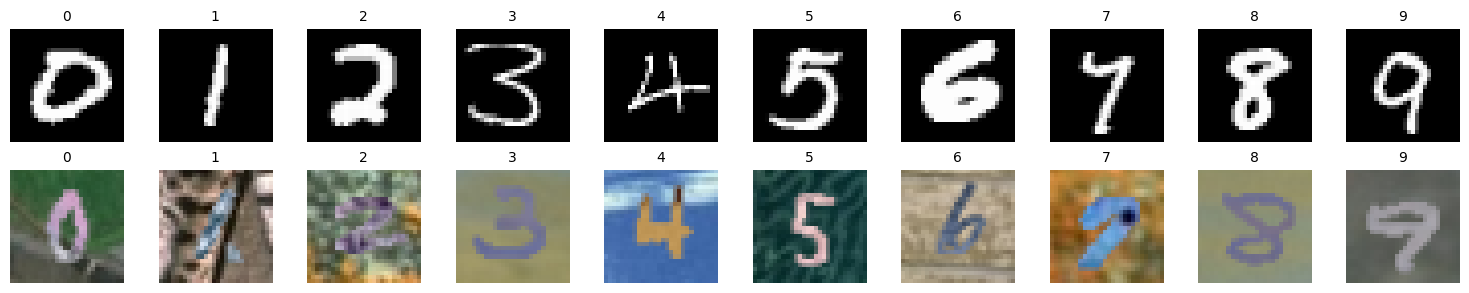

In [6]:
# Collect one example per digit from each dataset
def get_examples_by_label(dataset):
    label_to_img = {}
    for img, label in dataset:
        label = int(label)
        if label not in label_to_img:
            label_to_img[label] = img
        if len(label_to_img) == 10:
            break
    return label_to_img

def unnormalize(img, mean, std):
    img = img.clone()  # avoid modifying original
    for c in range(img.shape[0]):
        img[c] = img[c] * std[c] + mean[c]
    return img

# Get examples
mnist_digits = get_examples_by_label(mnist_train)
mnistm_digits = get_examples_by_label(mnistm_train)

# Plot
fig, axes = plt.subplots(2, 10, figsize=(15, 3))

for i in range(10):
    # MNIST row (top)
    img_mnist = unnormalize(mnist_digits[i], mnist_mean, mnist_std)  # unnormalize before imshow

    axes[0, i].imshow(img_mnist.permute(1, 2, 0).numpy())
    axes[0, i].set_title(f"{i}", fontsize=10)
    axes[0, i].axis("off")

    # MNIST-M row (bottom)
    img_mnistm = unnormalize(mnistm_digits[i], mnistm_mean, mnistm_std)  # unnormalize before imshow
    axes[1, i].imshow(img_mnistm.permute(1, 2, 0).numpy())
    axes[1, i].set_title(f"{i}", fontsize=10)
    axes[1, i].axis("off")

axes[0, 0].set_ylabel("MNIST", fontsize=12)
axes[1, 0].set_ylabel("MNIST-M", fontsize=12)
plt.tight_layout()
plt.show();

Images look good, now lets just check that the shapes are the same for training, and that the z-score normalization statistics look ok.

In [7]:
# Get a sample image from each dataset
mnist_image = next(iter(DataLoader(mnist_train, batch_size=1)))[0]
mnistm_image = next(iter(DataLoader(mnistm_train, batch_size=1)))[0]

# Print the shapes
print("MNIST image shape:", mnist_image.shape) # should be (3, 28, 28)
print("MNIST-M image shape:", mnistm_image.shape) # should be (3, 28, 28)
print("MNIST image stats:", torch.mean(mnist_image), torch.std(mnist_image)) ## should be close to 0 and 1
print("MNIST-M image stats:", torch.mean(mnistm_image), torch.std(mnistm_image)) ## should be close to 0 and 1

MNIST image shape: torch.Size([1, 3, 28, 28])
MNIST-M image shape: torch.Size([1, 3, 28, 28])
MNIST image stats: tensor(0.6033) tensor(1.4590)
MNIST-M image stats: tensor(-0.1476) tensor(0.5310)


Now let's define our model. We will write a simple CNN thats designed for classification, so that things can run quickly. There are a couple things to think carefully about here:

- The important difference with models used for DA training is that you are using the latent vector $z$ and the output logits. Write the forward pass to reflect this. That is, the full NN $f_\theta$ should output both the $\phi_\theta$ branch and $g_\theta$ branch.
- The efficacy of DA is primarily dependent on the expressivity of $\phi_\theta$. Do you expect this model to work well? Why or why not?
- Do we want the dimension of the latent vector to be small or large? Why or why not? 
- There are other NN architectural components (not included) that generally are thought to help generalization. What are some of these?

*stretch question:* you may have heard about symmetry-aware equivariant models. A NN like the one defined below is manifestly translation-equivariant, but many images in Nature contain higher-order symmetries (e.g., rotations, reflections). Would you expect an equivariant model to generalize better? Under what conditions would this happen, and under what conditions would this not?

Try to make a guess for how our model will perform before you proceed. Make note of your answers below:

In [8]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten_dim = 32 * 14 * 14
        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        z = x.view(-1, self.flatten_dim)
        z = F.relu(self.fc1(z))
        out = self.fc2(z)
        return out, z


Lets proceed to train this model. We will train the CNN without domain adaptation on $\mathcal{D}_s$, and test it on both $\mathcal{D}_s$ and $\mathcal{D}_t$. This will serve as a performance baseline. Much of this training loop is standard. We will use `AdamW` optimizer with a learning rate of `1e-3`. Usually, one would split their training set further to include a validation set, and the best model will be saved according to that. For this simple example, we will just save the model according to the training set performance.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
CE_only_model = CNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(CE_only_model.parameters(), lr=1e-3)
best_model = None
best_loss = float('inf')
# Training loop
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    CE_only_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in source_train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs, _ = CE_only_model(images) ## not using latent z for now
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model = copy.deepcopy(CE_only_model.state_dict())


        # Track training stats
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {running_loss/len(source_train_loader):.4f}  Accuracy: {100*correct/total:.2f}%")

Using device: cpu


 10%|█         | 1/10 [00:01<00:10,  1.19s/it]

Epoch [1/10]  Loss: 0.6661  Accuracy: 78.97%


 20%|██        | 2/10 [00:02<00:09,  1.15s/it]

Epoch [2/10]  Loss: 0.2239  Accuracy: 93.33%


 30%|███       | 3/10 [00:03<00:07,  1.12s/it]

Epoch [3/10]  Loss: 0.1338  Accuracy: 96.00%


 40%|████      | 4/10 [00:04<00:06,  1.13s/it]

Epoch [4/10]  Loss: 0.0866  Accuracy: 97.40%


 50%|█████     | 5/10 [00:05<00:05,  1.15s/it]

Epoch [5/10]  Loss: 0.0549  Accuracy: 98.50%


 60%|██████    | 6/10 [00:06<00:04,  1.18s/it]

Epoch [6/10]  Loss: 0.0401  Accuracy: 98.85%


 70%|███████   | 7/10 [00:08<00:03,  1.18s/it]

Epoch [7/10]  Loss: 0.0295  Accuracy: 99.12%


 80%|████████  | 8/10 [00:09<00:02,  1.21s/it]

Epoch [8/10]  Loss: 0.0438  Accuracy: 98.70%


 90%|█████████ | 9/10 [00:10<00:01,  1.20s/it]

Epoch [9/10]  Loss: 0.0151  Accuracy: 99.70%


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

Epoch [10/10]  Loss: 0.0054  Accuracy: 99.95%


The loss went down and accuracy went up. All is well. For a more complex dataset, this would probably be trained for longer, and with some additional bells and whistles during training (validation, L2-regularization, gradient clipping, etc.) for better performance. But this will suffice for now. Now, lets test the model on both domains!

In [10]:
def test_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Test on source domain (MNIST)
CE_only_model.load_state_dict(best_model)
source_accuracy = test_model(CE_only_model, source_test_loader, device)
print(f"Accuracy on source domain (MNIST): {source_accuracy:.2f}%")

# Test on target domain (MNIST-M)
target_accuracy = test_model(CE_only_model, target_test_loader, device)
print(f"Accuracy on target domain (MNIST-M): {target_accuracy:.2f}%")

Accuracy on source domain (MNIST): 96.10%
Accuracy on target domain (MNIST-M): 43.06%


We see that the model has a >50% discrepancy between the source and target domain. Despite this pretty mild covariate shift, the model is failing horribly to generalize! Moreover, we saw from visualizing the images earlier that MNIST and MNIST-M dont look *too* different. This is important. **Typically trained NNs aren't learning robust features**. Now, lets move to domain adaptation and see if we can shrink this performance gap between $\mathcal{D}_s$ and $\mathcal{D}_t$.

In [11]:
!pip install -q geomloss

## Training with Distance-based Domain Adaptation

We use [`geomloss`](https://www.kernel-operations.io/geomloss/api/pytorch-api.html) to compute distributional distances between the latent representations of source and target examples. This library provides differentiable loss functions between samples or measures, making it well-suited for domain adaptation (DA). In this setup, the distance serves to **align the source and target latent distributions** without using target labels during backpropagation.

There are a variety of distances implemented in `geomloss`, such as Sinkhorn divergences and energy distances. In this example, we use the **energy distance**, which is equivalent to a Gaussian Maximum Mean Discrepancy (MMD) with a fixed bandwidth. You are encouraged to experiment with [other options](https://www.kernel-operations.io/geomloss/api/pytorch-api.html) and tune the DA loss strength $\lambda_{\text{MMD}}$ to explore their effects on adaptation performance.

We'll train our model for longer than before. Also, since we have access to our target labels, we’ll track target domain accuracy during training. In a general problem setting where target labels are unavailable, this wouldn't be possible — but for teaching purposes, it's a useful diagnostic. Importantly, **target labels are not used for backpropagation** and do not influence the model updates. We also save the model only according to training loss performance, not target domain accuracy.


#### Gaussian Maximum Mean Discrepancy (MMD)

Let $z_s \sim \mathbb{P}_s$ and $z_t \sim \mathbb{P}_t$ be the latent representations of source and target inputs respectively. The squared Gaussian MMD between these two distributions is defined as:

\begin{align}
\mathcal{L}_{\text{MMD}}(\theta) &\equiv \text{MMD}^2(\mathbb{P}_s, \mathbb{P}_t) \\
&= \mathbb{E}_{z, z' \sim \mathbb{P}_s} [k(z, z')] + \mathbb{E}_{\tilde{z}, \tilde{z}' \sim \mathbb{P}_t} [k(\tilde{z}, \tilde{z}')] - 2 \mathbb{E}_{z \sim \mathbb{P}_s,\, \tilde{z} \sim \mathbb{P}_t} [k(z, \tilde{z})],
\end{align}

where $k(z, \tilde{z}) = \exp\left( -\frac{\|z - \tilde{z}\|^2}{2\sigma^2} \right)$ is a Gaussian kernel with bandwidth $\sigma$. The full loss minimized during training is:

$$
\mathcal{L}_{\text{total}}(\theta) = \mathcal{L}_{\text{CE}}(\theta) + \lambda_{\text{MMD}} \cdot \mathcal{L}_{\text{MMD}}(\theta),
$$

where $\lambda_{\text{MMD}}$ controls the strength of the domain adaptation penalty. The goal is to correctly classify source examples while encouraging the latent feature distributions of source and target data to align.


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from geomloss import SamplesLoss

num_epochs = 30
# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

DA_model = CNN().to(device)  # CNN should return (logits, z)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(DA_model.parameters(), lr=5e-3)
lambda_mmd = 0.2
geomloss_fn = SamplesLoss("energy", p=2) # GeomLoss with Sinkhorn distance, p=2, blur ~ σ; tune as needed
best_model = None
best_loss = float('inf')

# --- Training ---
for epoch in tqdm(range(num_epochs)):
    DA_model.train()
    running_loss, correct_s, correct_t, total_s, total_t = 0.0, 0, 0, 0, 0
    running_DA, running_CE = 0.0, 0.0

    for (source_imgs, source_labels), (target_imgs, target_labels) in zip(source_train_loader, target_train_loader):
        source_imgs, source_labels = source_imgs.to(device), source_labels.to(device)
        target_imgs, target_labels = target_imgs.to(device), target_labels.to(device)

        # --- Concatenate images and forward ---
        combined_imgs = torch.cat([source_imgs, target_imgs], dim=0)
        logits, z = DA_model(combined_imgs)

        # --- Split latent vectors and outputs ---
        z_s, z_t = z[:source_imgs.size(0)], z[source_imgs.size(0):]
        logits_s = logits[:source_imgs.size(0)]
        logits_t = logits[source_imgs.size(0):]

        # --- Compute losses ---
        ce_loss = criterion(logits_s, source_labels)
        mmd_loss = geomloss_fn(z_s, z_t)  # ← GeomLoss replaces MMD here
        total_loss = ce_loss + lambda_mmd * mmd_loss
        
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_model = copy.deepcopy(DA_model.state_dict())


        # --- Backpropagation ---
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # --- Metrics ---
        running_loss += total_loss.item()
        running_CE += ce_loss.item()
        running_DA += mmd_loss.item()
        _, predicted_s = logits_s.max(1)
        total_s += source_labels.size(0)
        correct_s += predicted_s.eq(source_labels).sum().item()
        _, predicted_t = logits_t.max(1)
        total_t += target_labels.size(0)
        correct_t += predicted_t.eq(target_labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], CE Loss: {running_CE/len(source_train_loader):.4f}, DA Loss: {running_DA/len(source_train_loader):.4f} Source Acc: {100*correct_s/total_s:.2f}%, Target Acc: {100*correct_t/total_t:.2f}%")

Using device: cpu


  3%|▎         | 1/30 [00:02<01:10,  2.42s/it]

Epoch [1/30], CE Loss: 0.9638, DA Loss: 1.2304 Source Acc: 74.45%, Target Acc: 30.90%


  7%|▋         | 2/30 [00:04<01:07,  2.40s/it]

Epoch [2/30], CE Loss: 0.2478, DA Loss: 0.8789 Source Acc: 92.75%, Target Acc: 39.63%


 10%|█         | 3/30 [00:07<01:04,  2.39s/it]

Epoch [3/30], CE Loss: 0.1426, DA Loss: 0.7748 Source Acc: 96.40%, Target Acc: 41.34%


 13%|█▎        | 4/30 [00:09<01:02,  2.40s/it]

Epoch [4/30], CE Loss: 0.0911, DA Loss: 0.7269 Source Acc: 97.97%, Target Acc: 42.44%


 17%|█▋        | 5/30 [00:12<01:00,  2.42s/it]

Epoch [5/30], CE Loss: 0.0687, DA Loss: 0.7074 Source Acc: 98.58%, Target Acc: 42.91%


 20%|██        | 6/30 [00:14<00:58,  2.42s/it]

Epoch [6/30], CE Loss: 0.0530, DA Loss: 0.6325 Source Acc: 99.05%, Target Acc: 43.80%


 23%|██▎       | 7/30 [00:16<00:55,  2.41s/it]

Epoch [7/30], CE Loss: 0.0363, DA Loss: 0.5463 Source Acc: 99.55%, Target Acc: 44.79%


 27%|██▋       | 8/30 [00:19<00:52,  2.38s/it]

Epoch [8/30], CE Loss: 0.0264, DA Loss: 0.4833 Source Acc: 99.80%, Target Acc: 46.43%


 30%|███       | 9/30 [00:21<00:49,  2.38s/it]

Epoch [9/30], CE Loss: 0.0241, DA Loss: 0.4869 Source Acc: 99.85%, Target Acc: 46.70%


 33%|███▎      | 10/30 [00:24<00:48,  2.45s/it]

Epoch [10/30], CE Loss: 0.0300, DA Loss: 0.4905 Source Acc: 99.65%, Target Acc: 46.11%


 37%|███▋      | 11/30 [00:26<00:46,  2.47s/it]

Epoch [11/30], CE Loss: 0.0244, DA Loss: 0.4668 Source Acc: 99.70%, Target Acc: 45.73%


 40%|████      | 12/30 [00:29<00:44,  2.49s/it]

Epoch [12/30], CE Loss: 0.0194, DA Loss: 0.4415 Source Acc: 99.85%, Target Acc: 47.62%


 43%|████▎     | 13/30 [00:31<00:41,  2.46s/it]

Epoch [13/30], CE Loss: 0.0150, DA Loss: 0.4123 Source Acc: 99.95%, Target Acc: 48.29%


 47%|████▋     | 14/30 [00:33<00:38,  2.41s/it]

Epoch [14/30], CE Loss: 0.0139, DA Loss: 0.3713 Source Acc: 99.97%, Target Acc: 50.30%


 50%|█████     | 15/30 [00:36<00:36,  2.45s/it]

Epoch [15/30], CE Loss: 0.0141, DA Loss: 0.3551 Source Acc: 99.97%, Target Acc: 48.69%


 53%|█████▎    | 16/30 [00:38<00:34,  2.45s/it]

Epoch [16/30], CE Loss: 0.0117, DA Loss: 0.3338 Source Acc: 99.97%, Target Acc: 50.15%


 57%|█████▋    | 17/30 [00:41<00:31,  2.44s/it]

Epoch [17/30], CE Loss: 0.0111, DA Loss: 0.3364 Source Acc: 100.00%, Target Acc: 50.12%


 60%|██████    | 18/30 [00:43<00:29,  2.46s/it]

Epoch [18/30], CE Loss: 0.0133, DA Loss: 0.3353 Source Acc: 99.95%, Target Acc: 48.39%


 63%|██████▎   | 19/30 [00:46<00:28,  2.55s/it]

Epoch [19/30], CE Loss: 0.0112, DA Loss: 0.3094 Source Acc: 99.97%, Target Acc: 50.69%


 67%|██████▋   | 20/30 [00:49<00:25,  2.53s/it]

Epoch [20/30], CE Loss: 0.0092, DA Loss: 0.2842 Source Acc: 100.00%, Target Acc: 49.31%


 70%|███████   | 21/30 [00:52<00:24,  2.69s/it]

Epoch [21/30], CE Loss: 0.0083, DA Loss: 0.2713 Source Acc: 100.00%, Target Acc: 51.07%


 73%|███████▎  | 22/30 [00:54<00:21,  2.69s/it]

Epoch [22/30], CE Loss: 0.0090, DA Loss: 0.2594 Source Acc: 100.00%, Target Acc: 51.96%


 77%|███████▋  | 23/30 [00:57<00:18,  2.59s/it]

Epoch [23/30], CE Loss: 0.0078, DA Loss: 0.2520 Source Acc: 100.00%, Target Acc: 50.02%


 80%|████████  | 24/30 [00:59<00:15,  2.57s/it]

Epoch [24/30], CE Loss: 0.0098, DA Loss: 0.2741 Source Acc: 99.97%, Target Acc: 51.84%


 83%|████████▎ | 25/30 [01:02<00:12,  2.53s/it]

Epoch [25/30], CE Loss: 0.0079, DA Loss: 0.2608 Source Acc: 100.00%, Target Acc: 50.74%


 87%|████████▋ | 26/30 [01:04<00:09,  2.46s/it]

Epoch [26/30], CE Loss: 0.0080, DA Loss: 0.2598 Source Acc: 100.00%, Target Acc: 51.93%


 90%|█████████ | 27/30 [01:07<00:07,  2.54s/it]

Epoch [27/30], CE Loss: 0.0082, DA Loss: 0.2520 Source Acc: 99.97%, Target Acc: 51.44%


 93%|█████████▎| 28/30 [01:09<00:05,  2.52s/it]

Epoch [28/30], CE Loss: 0.3540, DA Loss: 0.7752 Source Acc: 93.80%, Target Acc: 40.58%


 97%|█████████▋| 29/30 [01:11<00:02,  2.46s/it]

Epoch [29/30], CE Loss: 0.7788, DA Loss: 1.2121 Source Acc: 77.00%, Target Acc: 25.69%


100%|██████████| 30/30 [01:14<00:00,  2.48s/it]

Epoch [30/30], CE Loss: 0.1663, DA Loss: 0.9089 Source Acc: 95.40%, Target Acc: 33.01%


In [13]:
DA_model.load_state_dict(best_model)
source_accuracy = test_model(DA_model, source_test_loader, device)
print(f"Accuracy on source domain (MNIST): {source_accuracy:.2f}%")

# Test on target domain (MNIST-M)
target_accuracy = test_model(DA_model, target_test_loader, device)
print(f"Accuracy on target domain (MNIST-M): {target_accuracy:.2f}%")

Accuracy on source domain (MNIST): 96.80%
Accuracy on target domain (MNIST-M): 52.52%


DA works! This is a a pretty modest improvement over the basic NN for the target domain, and we also see similar performance on the source domain. This may not seem like a lot, and this is actually expected. Can you think why? Recall that the efficacy of DA relies on the *expressivity* of $\phi_\theta$: how well it could learn features. In a CNN, much of the feauture learning is done by convolutional layers; in our architecture we just have one! In addition to this, there's several other axes that contribute to how well the model gets aligned:

- training configurations
- choice of distance kernel
- dataset normalization

Feel free to experiment on some or all of these axes, especially in making the CNN deeper and more expressive, and you should see the domain alignment increase.

---

Trying an Adversarial Approach
---

We've seen how to implement a distance-based DA approach; now, we turn to another family of domain adaptation (DA) methods: **adversarial approaches**.

In adversarial domain adaptation, we again rely on the feature extractor $\phi_\theta(x)$ to map both source and target images into a shared latent space $z = \phi_\theta(x) \in \mathbb{R}^d$. The goal is to learn representations that are discriminative for the source task yet domain-invariant, such that a classifier trained on the source domain generalizes to the target.

To achieve this, we introduce an auxiliary domain classifier $d_\theta : \mathbb{R}^d \rightarrow [0,1]$ that tries to distinguish whether a latent vector $z$ comes from the source or target domain.

Let $\mathcal{D}_s = \{(x_s^{(i)}, y_s^{(i)})\}_{i=1}^{N_s}$ and $\mathcal{D}_t = \{x_t^{(j)}\}_{j=1}^{N_t}$ as before. During training, we optimize two competing objectives:

- **Source classification loss** (same as before):
  $$
  \mathcal{L}_{\text{CE}}(\theta) = -\frac{1}{N_s} \sum_{i=1}^{N_s} \log f_\theta^{(y_s^{(i)})}(x_s^{(i)}),
  $$

- **Domain adversarial loss**:
  $$
  \mathcal{L}_{\text{dom}}(\theta) = -\frac{1}{N_s} \sum_{i=1}^{N_s} \log d_\theta(\phi_\theta(x_s^{(i)}))
  - \frac{1}{N_t} \sum_{j=1}^{N_t} \log \left(1 - d_\theta(\phi_\theta(x_t^{(j)}))\right)
  $$

Here, the domain classifier $d_\theta$ is trained to maximize $\mathcal{L}_{\text{dom}}$ (i.e., correctly distinguish domains), while the feature extractor $\phi_\theta$ is trained to minimize it,  confusing the domain classifier and aligning the representations to be domain-invariant.

This adversarial interaction is implemented using a gradient reversal layer (GRL), which multiplies the gradient from $\mathcal{L}_{\text{dom}}$ by $-1$ before backpropagating through $\phi_\theta$.

The total loss function is:
$$
\mathcal{L}_{\text{total}}(\theta) = \mathcal{L}_{\text{CE}}(\theta) + \lambda \cdot \mathcal{L}_{\text{dom}}(\theta),
$$
where $\lambda$ balances the classification and domain alignment objectives.

In the next section, we'll implement this framework using the Domain-Adversarial Neural Network (DANN) and compare it directly against MMD-based adaptation.


In [29]:
from torch.autograd import Function
import torch.nn as nn
import torch.optim as optim

# --- Gradient Reversal Layer ---
class GradientReversal(Function):
    @staticmethod
    def forward(ctx, x, lambda_grl):
        ctx.lambda_grl = lambda_grl
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_grl * grad_output, None

def grad_reverse(x, lambda_grl=1.0):
    return GradientReversal.apply(x, lambda_grl)

# --- Domain Classifier ---
class DomainClassifier(nn.Module):
    def __init__(self, in_dim):
        super(DomainClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)  # Binary output
        )

    def forward(self, z, lambda_grl=1.0):
        z_rev = grad_reverse(z, lambda_grl)
        return self.net(z_rev)


In [30]:
adversarial_model = CNN().to(device)

domain_classifier = DomainClassifier(in_dim=128).to(device)  # set z_dim to latent dimension of your CNN
optimizer_DANN = optim.AdamW(
    list(adversarial_model.parameters()) + list(domain_classifier.parameters()), lr=1e-3
)
criterion_ce = nn.CrossEntropyLoss()
criterion_domain = nn.BCEWithLogitsLoss()
lambda_grl = 0.15
num_epochs = 20
best_model = None
best_loss = float('inf')

for epoch in range(num_epochs):
    adversarial_model.train()
    domain_classifier.train()

    running_loss, running_ce, running_da = 0.0, 0.0, 0.0
    correct_s, correct_t, total_s, total_t = 0, 0, 0, 0

    for (x_s, y_s), (x_t, y_t) in zip(source_train_loader, target_train_loader):
        x_s, y_s = x_s.to(device), y_s.to(device)
        x_t, y_t = x_t.to(device), y_t.to(device)

        # --- Forward pass ---
        x = torch.cat([x_s, x_t], dim=0)
        domain_labels = torch.cat([
            torch.ones(x_s.size(0), 1),
            torch.zeros(x_t.size(0), 1)
        ], dim=0).to(device)

        logits, z = adversarial_model(x)
        z_s, z_t = z[:x_s.size(0)], z[x_s.size(0):]
        logits_s = logits[:x_s.size(0)]
        logits_t = logits[x_s.size(0):]

        # --- Losses ---
        loss_ce = criterion_ce(logits_s, y_s)
        domain_logits = domain_classifier(z, lambda_grl)
        loss_da = criterion_domain(domain_logits, domain_labels)
        loss_total = loss_ce + lambda_grl * loss_da
        
        if loss_total.item() < best_loss:
            best_loss = loss_total.item()
            best_model = copy.deepcopy(adversarial_model.state_dict())

        # --- Backward ---
        optimizer_DANN.zero_grad()
        loss_total.backward()
        optimizer_DANN.step()

        # --- Accuracy tracking ---
        _, pred_s = logits_s.max(1)
        _, pred_t = logits_t.max(1)
        correct_s += pred_s.eq(y_s).sum().item()
        correct_t += pred_t.eq(y_t).sum().item()
        total_s += y_s.size(0)
        total_t += y_t.size(0)

        running_loss += loss_total.item()
        running_ce += loss_ce.item()
        running_da += loss_da.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"CE Loss: {running_ce/len(source_train_loader):.4f}, "
          f"DA Loss: {running_da/len(source_train_loader):.4f}, "
          f"Source Acc: {100 * correct_s / total_s:.2f}%, "
          f"Target Acc: {100 * correct_t / total_t:.2f}%")


Epoch [1/20] CE Loss: 0.5982, DA Loss: 0.5878, Source Acc: 81.40%, Target Acc: 32.14%
Epoch [2/20] CE Loss: 0.2025, DA Loss: 0.3329, Source Acc: 93.75%, Target Acc: 39.04%
Epoch [3/20] CE Loss: 0.1170, DA Loss: 0.1210, Source Acc: 96.38%, Target Acc: 40.75%
Epoch [4/20] CE Loss: 0.0671, DA Loss: 0.3314, Source Acc: 97.97%, Target Acc: 41.27%
Epoch [5/20] CE Loss: 0.0505, DA Loss: 0.0651, Source Acc: 98.40%, Target Acc: 39.78%
Epoch [6/20] CE Loss: 0.0324, DA Loss: 0.2590, Source Acc: 99.12%, Target Acc: 41.52%
Epoch [7/20] CE Loss: 0.0212, DA Loss: 0.1800, Source Acc: 99.47%, Target Acc: 41.57%
Epoch [8/20] CE Loss: 0.0135, DA Loss: 0.2734, Source Acc: 99.67%, Target Acc: 42.53%
Epoch [9/20] CE Loss: 0.0097, DA Loss: 0.0678, Source Acc: 99.80%, Target Acc: 43.15%
Epoch [10/20] CE Loss: 0.0045, DA Loss: 0.3350, Source Acc: 99.95%, Target Acc: 43.73%
Epoch [11/20] CE Loss: 0.0036, DA Loss: 0.2238, Source Acc: 100.00%, Target Acc: 44.37%
Epoch [12/20] CE Loss: 0.0080, DA Loss: 0.2524, Sou

In [31]:
adversarial_model.load_state_dict(best_model)

source_acc = test_model(adversarial_model, source_test_loader, device)
target_acc = test_model(adversarial_model, target_test_loader, device)

print(f"Source Test Accuracy: {source_acc:.2f}%")
print(f"Target Test Accuracy: {target_acc:.2f}%")


Source Test Accuracy: 96.60%
Target Test Accuracy: 49.22%


We see that our adversarial approach was also succesful, though less performant than the distance-based approach. In general, one can find that adversarial approaches can *exceed* distance-based approaches for DA, though requiring much more hyperparameter tuning. We have done none of that, which can explain the discrepancy.

---

## Studying Isomaps

We have now trained three models: `CE_only_model`, `DA_model`, and `adversarial_model`, with varying performance on the target domain. These models used the same underlying CNN. It's now interesting to study how these models latent representations differ, and what that can tell us about the success and failure points of the respective training methods.

Recall that our latent space $z$ is high-dimensional. In this case, 128-d. To understand any relevant structure *as people*, we will have to project this down to 2D. Luckily, there are a variety of methods designed to do this.

One such method is [Isomaps](https://en.wikipedia.org/wiki/Isomap). The isomap method reduces dimensionality by preserving geodesic (manifold) distances between points. First, a neighborhood graph is built using $k$-nearest neighbors. Geodesic distances $D_{ij}$ are then estimated via shortest paths over this graph. Finally, classical MDS is applied to the resulting distance matrix. The embedding is given by the top two eigenvectors of:

$$
\mathbf{B} = -\frac{1}{2} \mathbf{H} D^2 \mathbf{H}, \quad \text{where } \mathbf{H} = \mathbf{I} - \frac{1}{N} \mathbf{1}\mathbf{1}^\top.
$$

This gives us a 2D projection that captures the global structure of the latent space.


/var/folders/pf/33l4yz9171b8fsbj1vymxs8m0000gn/T/ipykernel_94598/2226336710.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 10)
/var/folders/pf/33l4yz9171b8fsbj1vymxs8m0000gn/T/ipykernel_94598/2226336710.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 10)
/var/folders/pf/33l4yz9171b8fsbj1vymxs8m0000gn/T/ipykernel_94598/2226336710.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = 

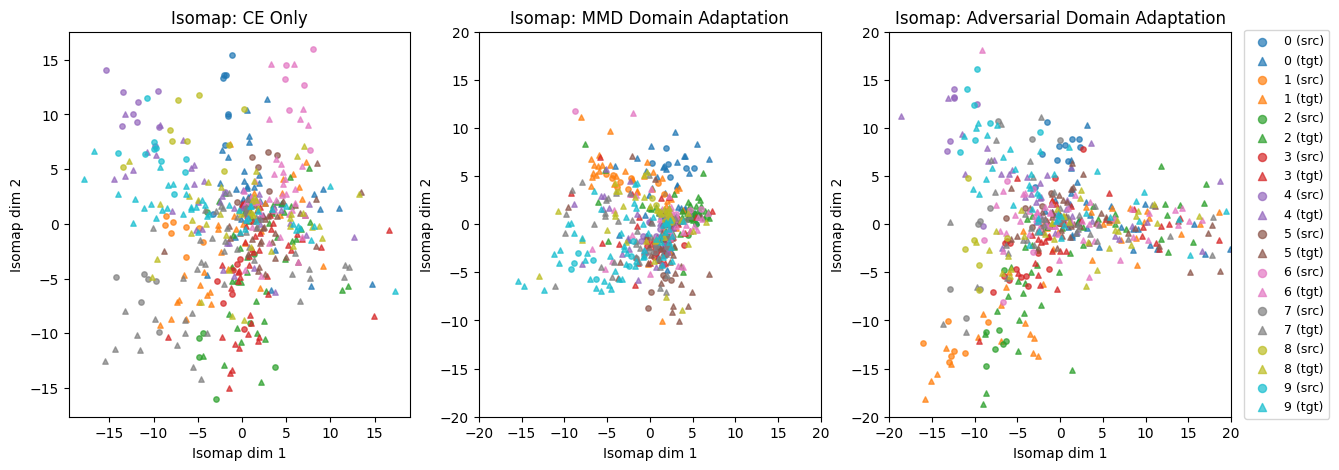

In [32]:
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler


def extract_latents_with_labels(model, source_loader, target_loader, device):
    model.eval()
    z_all, y_all, domains = [], [], []

    with torch.no_grad():
        for imgs, labels in source_loader:
            imgs = imgs.to(device)
            _, z = model(imgs)
            z_all.append(z.cpu())
            y_all.extend(labels.tolist())
            domains.extend(["source"] * len(labels))

        for imgs, labels in target_loader:
            imgs = imgs.to(device)
            _, z = model(imgs)
            z_all.append(z.cpu())
            y_all.extend(labels.tolist())
            domains.extend(["target"] * len(labels))

    z_all = torch.cat(z_all, dim=0)
    z_all = torch.tensor(StandardScaler().fit_transform(z_all))
    return z_all, np.array(y_all), np.array(domains)

def plot_isomap_with_colors_and_markers(z_all, y_all, domains, title, xlim=None, ylim=None, subset=500, ax=None, legend=False):

    # Fit Isomap
    isomap = Isomap(n_components=2, n_neighbors=20)
    z_2d = isomap.fit_transform(z_all.numpy())

    # Subsample
    indices = np.random.choice(len(z_all), size=subset, replace=False)
    z_2d = z_2d[indices]
    y_all = y_all[indices]
    domains = domains[indices]

    # Setup axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))

    # Define color map
    cmap = plt.cm.get_cmap('tab10', 10)

    # Plot by digit and domain
    for digit in range(10):
        color = cmap(digit)
        for domain, marker in zip(["source", "target"], ["o", "^"]):
            idx = (y_all == digit) & (domains == domain)
            ax.scatter(
                z_2d[idx, 0], z_2d[idx, 1],
                label=f"{digit} ({'src' if domain == 'source' else 'tgt'})",
                c=[color], marker=marker, s=15, alpha=0.7
            )

    ax.set_title(title)
    ax.set_xlabel("Isomap dim 1")
    ax.set_ylabel("Isomap dim 2")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if legend:
        ax.legend(markerscale=1.5, fontsize=9, loc='center left', bbox_to_anchor=(1.02, 0.5))

    if ax is None:
        plt.tight_layout()
        plt.show()


# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# CE-only model
z_ce, y_ce, d_ce = extract_latents_with_labels(CE_only_model, source_test_loader, target_test_loader, device)
plot_isomap_with_colors_and_markers(z_ce, y_ce, d_ce, "Isomap: CE Only", ax=axes[0], legend=False)

# MMD-based model
z_da, y_da, d_da = extract_latents_with_labels(DA_model, source_test_loader, target_test_loader, device)
plot_isomap_with_colors_and_markers(z_da, y_da, d_da, "Isomap: MMD Domain Adaptation", xlim =(-20, 20), ylim=(-20, 20), ax=axes[1], legend=False)

# Adversarial model
z_adv, y_adv, d_adv = extract_latents_with_labels(adversarial_model, source_test_loader, target_test_loader, device)
plot_isomap_with_colors_and_markers(z_adv, y_adv, d_adv, "Isomap: Adversarial Domain Adaptation", xlim =(-20, 20), ylim=(-20, 20), ax=axes[2], legend=True)


Ok, these don't look *that* great. We still do see a slight improvement in the latent spaces that include DA. And this, in fact, does make sense. We wouldn't expect perfect, nice clusters for each class as the target domain performance is still not perfectly aligned with the source. If you play around with things more and get the source domain performance on-par with the target domain, you should see some nice isomaps like the ones visualized [here](https://arxiv.org/abs/2501.14048). Thus concludes this tutorial. Happy coding!